# Image Denoising

#### By [Natalí de Santi](https://natalidesanti.github.io), email: natalidesanti@gmail.com

In this tutorial we will see examples of different **image denoising** techniques.

## Summary

* What is an image denoising?
* Data
* Data pre-processing
* Traditional Image Denoising Methods

## What is an image denoising?

The goal of **image denoising** is to recover a _clean version_ of an image $x$ from a _noisy observation_ $y$, 
where the _noise_ $\nu$ is typically modeled as _Gaussian_ with zero mean $\mu$ and standard deviation $\sigma$. 
Mathematically, this relationship is described by:
\begin{equation}
 y = x + \nu
\end{equation}
An _image denoiser_ should be able to produce a cleaned version $\hat{x}$ that closely resembles the original clean 
image $x$, by effectively reducing the noise present in the observed image $y$. 

It is crucial for the denoiser to **preserve** essential **properties** and **features** of the _original image_ 
**without introducing new artifacts** or **distortions**. Various methods have been developed to tackle the problem of 
image denoising, ranging from traditional image filters tailored to specific types of noise, to more sophisticated ML 
techniques. 

![Example of image denoising](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e8/ROF_Denoising_Example.png/400px-ROF_Denoising_Example.png)
###### Figure: Example of image denoising

## Libraries

In [1]:
try:
    import keras
    from keras.datasets import mnist
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy import ndimage
    from skimage import restoration
    from sklearn.metrics import mean_squared_error
except:
    from tensorflow import keras
    from tensorflow.keras.datasets import mnist
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy import ndimage
    from skimage import restoration
    from sklearn.metrics import mean_squared_error

## Data

Here, we are using as our data the [MNIST](https://keras.io/api/datasets/mnist/) dataset.

![](https://upload.wikimedia.org/wikipedia/commons/f/f7/MnistExamplesModified.png)
###### Figure: An eye into MNIST digits

This is a dataset of $60,000$ images of size $28 \times 28$ grayscale images of hand written of 
$10$ digits ($0, 1, 2, 3, 4, 5, 6, 7, 8, 9$), along with a test set of $10,000$ images.

### Importing data

This dataset is mostly used in _classification problems_, that is why they have the images and a second information, the labels of each image.

But, as we are going to map digits images to clean them, we are not going to use the labels.

In this way, our process is going to take the **noised images** and clear the same based into the **true images** as _targets_.

In [2]:
(x_train, _), (x_test, _) = mnist.load_data()

In [3]:
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

In [4]:
dimension = x_train.shape[1]

## Pre-processing data

Because here we are doing a simple example, we will use a fraction of the complete dataset: just 1000 images, dividing if on 700 as _train_ and 300 images as _test_

In [5]:
num_data = 1000
frac_train = 0.7
frac_test = 0.3
x_train = x_train[0:int(frac_train*num_data)]
x_test = x_test[0:int(frac_test*num_data)]

We are going to **normalize** the image pixel values between $0$ and $1$ and reshape them:

In [6]:
norm_factor = 255.
x_train = x_train.astype('float32')/norm_factor
x_test = x_test.astype('float32')/norm_factor
x_train = np.reshape(x_train, (len(x_train), dimension, dimension, 1))
x_test = np.reshape(x_test, (len(x_test), dimension, dimension, 1))

Here, we need to **add noise** to the images. One way of doing so is appling a _Gaussian noise_ to them, and clipping the image pixel values between $0$ and $1$:

In [7]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc = 0.0, scale = 1.0, size = x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc = 0.0, scale = 1.0, size = x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

Visualizing some noise images images.

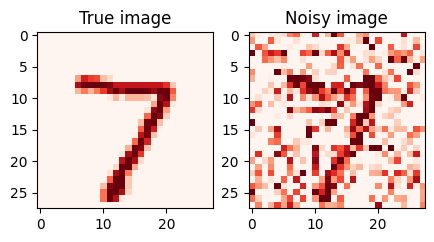

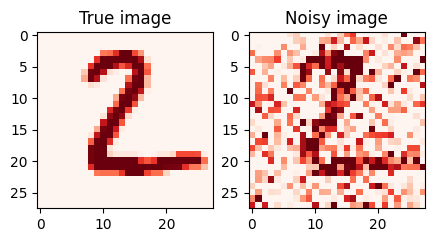

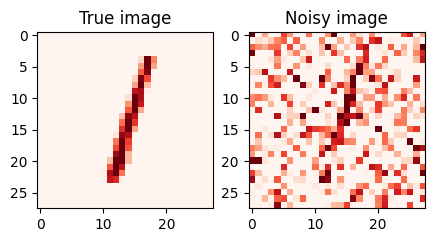

In [8]:
n = 3
for i in range(n):
    fig, axes = plt.subplots(1, 2)
    fig.set_size_inches(5, 5)
    axes[0].set_title('True image')
    im0 = axes[0].imshow(x_test[i].reshape(dimension, dimension), cmap = 'Reds')
    axes[1].set_title('Noisy image')
    im1 = axes[1].imshow(x_test_noisy[i].reshape(dimension, dimension), cmap = 'Reds')

## Traditional Image Denoising Methods

Now, we are going to see the effect of **traditional denoisers** on a sample of these noisy digits.

The set of them comprehend:
* **Gaussian filter:** that is responsible to apply a Gaussian filter with a defined Gaussian kernel
* **Median filter:** that calculates the median filter of the image in question, given the input to the filter
* **TV Chambole Denoiser:** performs a _total variation denoising_, finding an image with less total variation
* **Bilateral Filter:** denoise the image using a _bilateral filter_
* **Wavelet Denoiser:** performs a _wavelet denoising_ on an image

It is not the objective of the present tutorial to enter in all the details regarding to all these methods, but
an interested reader could see more details about them on their documentations ([skimage](https://scikit-image.org/docs/stable/api/skimage.restoration) and [ndimage](https://docs.scipy.org/doc/scipy/reference/ndimage.html)).

Let's select the **noisy digit** and apply the methods:

In [9]:
true = x_test[0]
noisy = x_test_noisy[0]
gauss_denoised = ndimage.gaussian_filter(noisy, 1.0)
med_denoised = ndimage.median_filter(noisy, 3)
tv = restoration.denoise_tv_chambolle(noisy, channel_axis=-1)
bilateral = restoration.denoise_bilateral(noisy, channel_axis=-1)
wavelet = restoration.denoise_wavelet(noisy, rescale_sigma=True, channel_axis=-1)
nl_means = restoration.denoise_nl_means(noisy)

/Users/natalidesanti/env_pytorch/lib/python3.11/site-packages/skimage/_shared/utils.py:449: UserWarning: Input image must be grayscale, RGB, or RGBA; but has shape (28, 28, 1).
  return func(*args, **kwargs)


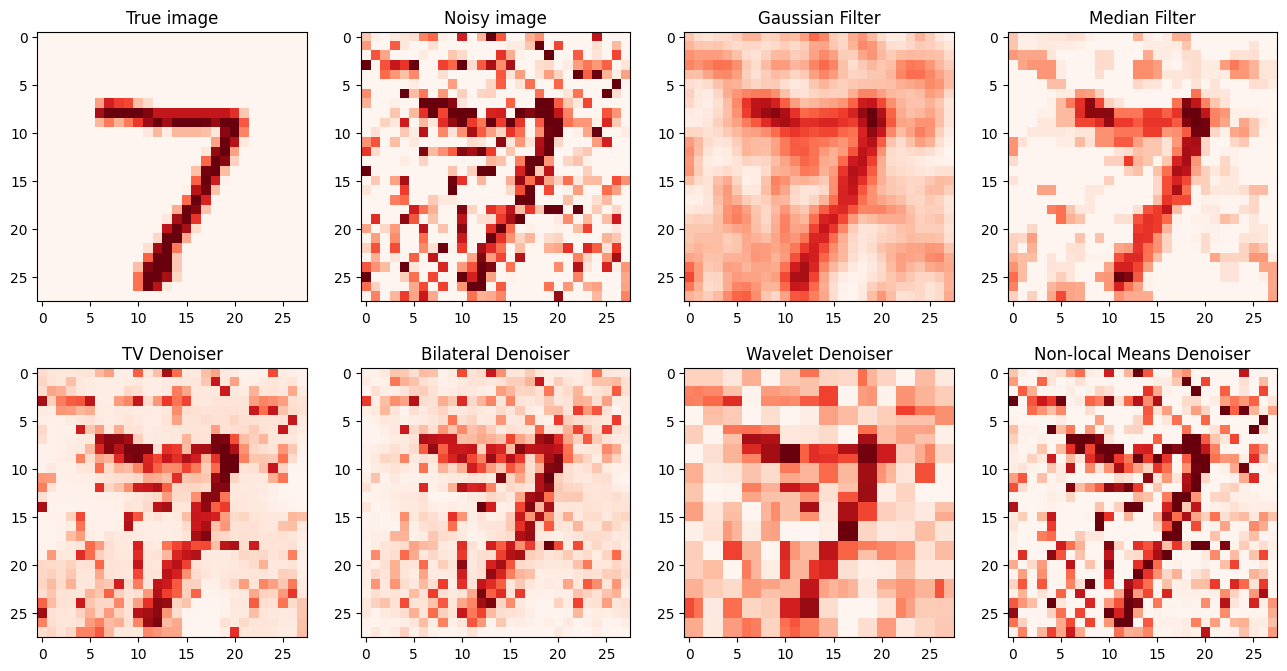

In [10]:
fig, axes = plt.subplots(2, 4)
fig.set_size_inches(16, 8)
axes[0,0].set_title('True image')
im0 = axes[0,0].imshow(true.reshape(dimension, dimension), cmap = 'Reds')
axes[0,1].set_title('Noisy image')
im1 = axes[0,1].imshow(x_test_noisy[0].reshape(dimension, dimension), cmap = 'Reds')
axes[0,2].set_title('Gaussian Filter')
im2 = axes[0,2].imshow(gauss_denoised.reshape(dimension, dimension), cmap = 'Reds')
axes[0,3].set_title('Median Filter')
im2 = axes[0,3].imshow(med_denoised.reshape(dimension, dimension), cmap = 'Reds')
axes[1,0].set_title('TV Denoiser')
im0 = axes[1,0].imshow(tv.reshape(dimension, dimension), cmap = 'Reds')
axes[1,1].set_title('Bilateral Denoiser')
im0 = axes[1,1].imshow(bilateral.reshape(dimension, dimension), cmap = 'Reds')
axes[1,2].set_title('Wavelet Denoiser')
im0 = axes[1,2].imshow(wavelet.reshape(dimension, dimension), cmap = 'Reds')
axes[1,3].set_title('Non-local Means Denoiser')
im0 = axes[1,3].imshow(nl_means.reshape(dimension, dimension), cmap = 'Reds')

It is clear that **none** of these methods is able to recover the **true image**. 
Although, we can compute the **mean squared error** between the _true_ and each of 
these _denoised_ images, to pick the best method and introduce a way to compare the 
images, that we will use later in this tutorial:

In [11]:
mse_gaussian = mean_squared_error(true[:, :, 0], gauss_denoised[:, :, 0])
mse_med = mean_squared_error(true[:, :, 0], med_denoised[:, :, 0])
mse_tv = mean_squared_error(true[:, :, 0], tv[:, :, 0])
mse_bilateral = mean_squared_error(true[:, :, 0], bilateral)
mse_wavelet = mean_squared_error(true[:, :, 0], wavelet[:, :, 0])
mse_nl = mean_squared_error(true[:, :, 0], nl_means)

In [12]:
mses = np.array([mse_gaussian, mse_med, mse_tv, mse_bilateral, mse_wavelet, mse_nl])
methods = ['Gaussian Filter', 'Median Filter', 'TV Denoiser', 'Bilateral Filter', 'Wavelet Denoiser', 'Non-local Means Denoiser']
best_mse = np.min(mses)
best = np.where(mses == best_mse)[0][0]
worse_mse = np.max(mses)
worse = np.where(mses == worse_mse)[0][0]

In [13]:
print('The best traditional denoiser is: ', methods[best], 'with MSE = ', best_mse)

The best traditional denoiser is:  Median Filter with MSE =  0.03140265285372438


In [14]:
print('The worse traditional denoiser is: ', methods[worse], 'with MSE = ', worse_mse)

The worse traditional denoiser is:  Non-local Means Denoiser with MSE =  0.11026099852656299


As expect due to the visual inspection!

The takeaway from these exercise is to see that the **traditional methods** do not solve the **noise problem**.

One of the reasons for this is because they are methods mostly **dedicated** to **specific kinds of noise**.

In the next notebooks of this tutorial we are going to explore **data-driven methods**, what means that they
are going to remove the _noise_ no matter the _nature_ of it.